In [1]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


In [11]:
df=pd.read_csv("../data/engineered_retail_data.csv")
df['Date'] = pd.to_datetime(df['Date'])

In [18]:
features = [
    'product_id',
    'product_mean', 'product_std', 'product_median',
    'cat_mean', 'brand_mean', 'type_mean',
    'country_mean', 'state_mean',
    'Month', 'DayOfWeek', 'Quarter',
    'lag_1','lag_7','lag_14','lag_30',
    'roll_7_mean','roll_30_mean','roll_30_std'
]


target = 'Total_Purchases'


In [19]:
df = df.sort_values("Date")

train_size = int(len(df) * 0.8)

train = df.iloc[:train_size]
test  = df.iloc[train_size:]


In [20]:
X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]


In [21]:
from xgboost import XGBRegressor

model = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=10,
    subsample=0.9,
    colsample_bytree=0.9,
    objective='reg:squarederror',
    random_state=42
)

model.fit(X_train, y_train)


,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.9
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None
,feature_types,None


In [22]:
preds = model.predict(X_test)


In [25]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(y_test, preds)
rmse = np.sqrt(mean_squared_error(y_test, preds))

print("Test MAE:", mae)
print("Test RMSE:", rmse)



Test MAE: 2.239411580897616
Test RMSE: 2.667111135900622


In [26]:
test['preds'] = preds

daily_actual = test.groupby('Date')['Total_Purchases'].sum()
daily_pred   = test.groupby('Date')['preds'].sum()


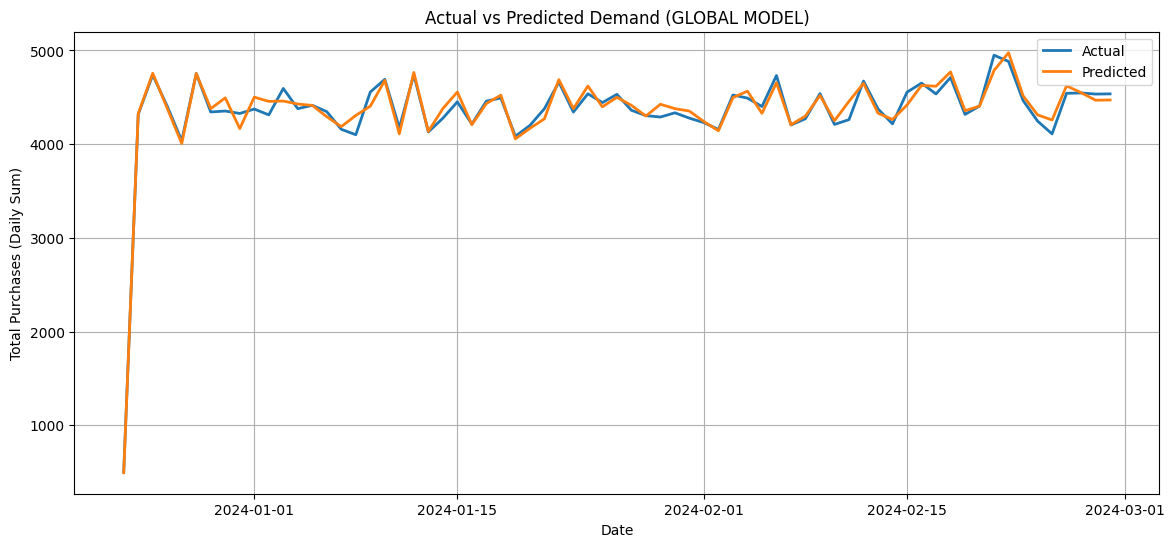

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))
plt.plot(daily_actual.index, daily_actual.values, label='Actual', linewidth=2)
plt.plot(daily_pred.index,   daily_pred.values,   label='Predicted', linewidth=2)
plt.title("Actual vs Predicted Demand (GLOBAL MODEL)")
plt.xlabel("Date")
plt.ylabel("Total Purchases (Daily Sum)")
plt.legend()
plt.grid(True)
plt.show()


In [29]:
from lightgbm import LGBMRegressor

In [30]:
model = LGBMRegressor(
    n_estimators=800,
    learning_rate=0.03,
    num_leaves=64,
    max_depth=-1,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_alpha=0.3,
    reg_lambda=0.3,
    random_state=42
)

model.fit(X_train, y_train)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005689 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1382
[LightGBM] [Info] Number of data points in the train set: 224879, number of used features: 19
[LightGBM] [Info] Start training from score 5.360585


,boosting_type,'gbdt'
,num_leaves,64
,max_depth,-1
,learning_rate,0.03
,n_estimators,800
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [31]:
preds = model.predict(X_test)


In [32]:
mae = mean_absolute_error(y_test, preds)
rmse = np.sqrt(mean_squared_error(y_test, preds))

print("LightGBM Test MAE:", mae)
print("LightGBM Test RMSE:", rmse)


LightGBM Test MAE: 2.2171754125767107
LightGBM Test RMSE: 2.6272625217444485


In [33]:
test["preds"] = preds

daily_actual = test.groupby("Date")["Total_Purchases"].sum()
daily_pred   = test.groupby("Date")["preds"].sum()


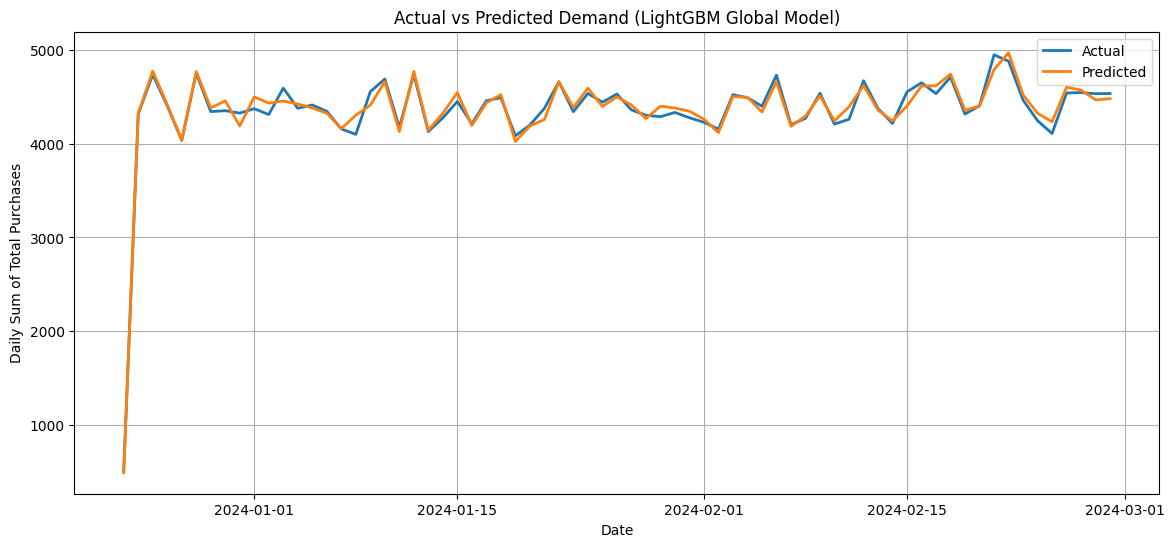

In [34]:
plt.figure(figsize=(14,6))
plt.plot(daily_actual.index, daily_actual.values, label="Actual", linewidth=2)
plt.plot(daily_pred.index, daily_pred.values, label="Predicted", linewidth=2)
plt.title("Actual vs Predicted Demand (LightGBM Global Model)")
plt.xlabel("Date")
plt.ylabel("Daily Sum of Total Purchases")
plt.legend()
plt.grid(True)
plt.show()
